# Framework

- Data - Palbociclib Data (Proteomics and GDSC2)
- Preprocessing method - missing data imputation by lower quantile (0 to 0.25)
- Feature selection (Filtering) - select features with pearson correlation >= |0.4|
- Model - Elastic Net
- Target variable used - AUC

In [39]:
import os 
import DataFunctions as utils
import Visualisation as vis
from toolkit import * 
import numpy as np
import pandas as pd

save_results_path = 'data//results//workbook-4-jun' 

if not os.path.exists(save_results_path):
    os.makedirs(save_results_path)

In [2]:
### Load data

import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import CCLE gene expression data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)


# import proteomic expression
with open('data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_fillna_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open('data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)


In [5]:
# using STRING database to select the 1st,2nd and 3rd degree neighbours of the drug target

drug_targets = ['CDK4', 'CDK6']
first_degree_neighbours = []
second_degree_neighbours = []
third_degree_neighbours = []

for drug_target in drug_targets:
    string_id = utils.get_protein_id_by_name(drug_target, string_df_info, string_df_alias)
    if string_id is not None:
        first_interactors_string_id = utils.get_protein_interactors(string_id, string_df, score_threshold=900)
        for ii in first_interactors_string_id:
            interactor_name = utils.get_protein_name_by_id(ii, goncalve_to_string_id_df, 
                                                           field_name='goncalve_protein_id',
                                                           check_field_name='string_protein_id')
            if interactor_name is not None:
                first_degree_neighbours.append(interactor_name)

first_degree_neighbours = list(set(first_degree_neighbours))

print(f'first degree neighbours size: {len(first_degree_neighbours)}')
print(f'first degree neighbours: {first_degree_neighbours}')
# get the second degree neighbours using first_interactors_string_id

for ii in first_interactors_string_id:
    second_interactors_string_id = utils.get_protein_interactors(ii, string_df, score_threshold=900)
    for sec_ii in second_interactors_string_id:
        interactor_name = utils.get_protein_name_by_id(sec_ii, goncalve_to_string_id_df, 
                                                       field_name='goncalve_protein_id',
                                                       check_field_name='string_protein_id')
        if interactor_name is not None:
            second_degree_neighbours.append(interactor_name)

second_degree_neighbours = list(set(second_degree_neighbours + first_degree_neighbours))
print(f'second degree neighbours size: {len(second_degree_neighbours)}')
print(f'second degree neighbours: {second_degree_neighbours}')


# get the third degree neighbours using second_interactors_string_id

for ii in second_interactors_string_id:
    third_interactors_string_id = utils.get_protein_interactors(ii, string_df, score_threshold=900)
    for third_ii in third_interactors_string_id:
        interactor_name = utils.get_protein_name_by_id(third_ii, goncalve_to_string_id_df, 
                                                       field_name='goncalve_protein_id',
                                                       check_field_name='string_protein_id')
        if interactor_name is not None:
            third_degree_neighbours.append(interactor_name)

third_degree_neighbours = list(set(third_degree_neighbours + second_degree_neighbours))
print(f'third degree neighbours size: {len(third_degree_neighbours)}')
print(f'third degree neighbours: {third_degree_neighbours}')
# verify a list is unique

def verify_unique_list(l):
    return len(l) == len(set(l))

# find duplicates in the list

def find_duplicates(l):
    return list(set([x for x in l if l.count(x) > 1]))

print(f'first degree neighbours is unique: {verify_unique_list(first_degree_neighbours)}')
print(f'second degree neighbours is unique: {verify_unique_list(second_degree_neighbours)}')
print(f'third degree neighbours is unique: {verify_unique_list(third_degree_neighbours)}')

# print the duplicates in first degree neighbours

print(f'duplicates in first degree neighbours: {find_duplicates(first_degree_neighbours)}')
print(f'duplicates in second degree neighbours: {find_duplicates(second_degree_neighbours)}')
print(f'duplicates in third degree neighbours: {find_duplicates(third_degree_neighbours)}')

nth_degree_neighbours = [drug_targets, first_degree_neighbours, second_degree_neighbours, third_degree_neighbours]


first degree neighbours size: 43
first degree neighbours: ['P11802;CDK4_HUMAN', 'P49918;CDN1C_HUMAN', 'P49841;GSK3B_HUMAN', 'P49715;CEBPA_HUMAN', 'P20248;CCNA2_HUMAN', 'Q00535;CDK5_HUMAN', 'P08238;HS90B_HUMAN', 'P12931;SRC_HUMAN', 'P24941;CDK2_HUMAN', 'Q16543;CDC37_HUMAN', 'P50613;CDK7_HUMAN', 'Q14186;TFDP1_HUMAN', 'P51946;CCNH_HUMAN', 'P16989;YBOX3_HUMAN', 'P42771;CDN2A_HUMAN', 'P07900;HS90A_HUMAN', 'P84022;SMAD3_HUMAN', 'Q13309;SKP2_HUMAN', 'Q00534;CDK6_HUMAN', 'Q13951;PEBB_HUMAN', 'P00519;ABL1_HUMAN', 'P10275;ANDR_HUMAN', 'P04637;P53_HUMAN', 'Q13485;SMAD4_HUMAN', 'P50750;CDK9_HUMAN', 'P06493;CDK1_HUMAN', 'Q9P287;BCCIP_HUMAN', 'O60563;CCNT1_HUMAN', 'P12004;PCNA_HUMAN', 'Q13547;HDAC1_HUMAN', 'P07948;LYN_HUMAN', 'P51948;MAT1_HUMAN', 'P24385;CCND1_HUMAN', 'P31947;1433S_HUMAN', 'P15090;FABP4_HUMAN', 'O43502;RA51C_HUMAN', 'O95067;CCNB2_HUMAN', 'Q9BWT6;MND1_HUMAN', 'O75832;PSD10_HUMAN', 'Q9P2W1;HOP2_HUMAN', 'P42773;CDN2C_HUMAN', 'P06400;RB_HUMAN', 'P14635;CCNB1_HUMAN']
second degree neighb

In [40]:
### Config Parameters

## Data 

# create the full dataset
drug_selected = 'Palbociclib'

## Preprocessing Method
# Between fill by zero, impute by random variable between 0 to 1st quantile
# Impute1stQuantile, Fill0, ImputeKNN
preprocessing_method = 'Impute1stQuantile'

# set threshold for feature removal (0.8 means remove features with > 80% missing values)
feature_nan_removal_threshold = 0.8

## Feature Selection Methods

## Models 
## Target variable used

target_variable = 'AUC'

## Hyperparameters
experiment_name = 'test'
save_input = True
save_output = True

# hyperparameters
max_gene_target_disance = 2 # specify the level of biological relevance to drug target(s)
statistical_filter_size = 100 # can be optimized using global feature dropout testing
monte_carlo_cross_validation_size = 50 # can be automatically optimized via rank impact assessment
models_used = ['ElasticNet']
models_hyperparameters = [{}]

# extra hyperparameters
statistical_filter_threshold = 0.05 # currently not in use
cv_split_size = 0.1

# generated hyperparameters
rng_seed_lists = []
for j in range(monte_carlo_cross_validation_size):
    rng_seed_lists.append(np.random.randint(100000))


verbose = True
max_feature_save_size = 1000
data_collector = []
conditions_to_test = ['network_f_regression_selection', 'whole_dataset_control', 'random_control']
conditions_to_get_feature_importance = [True, False, False]
matched_functions = [get_network_stat_features, get_all_features, get_random_features]
extra_args = [(nth_degree_neighbours, max_gene_target_disance, statistical_filter_size), (), (statistical_filter_size,)]
features_to_knockout = []

NameError: name 'nth_degree_neighbours' is not defined

In [6]:
data_df = utils.create_joint_dataset_from_proteome_gdsc(drug_selected, joined_sin_peptile_exclusion_matrix, gdsc2, drug_value=target_variable)
feature_data, label_data = utils.create_feature_and_label(data_df, label_name=target_variable)

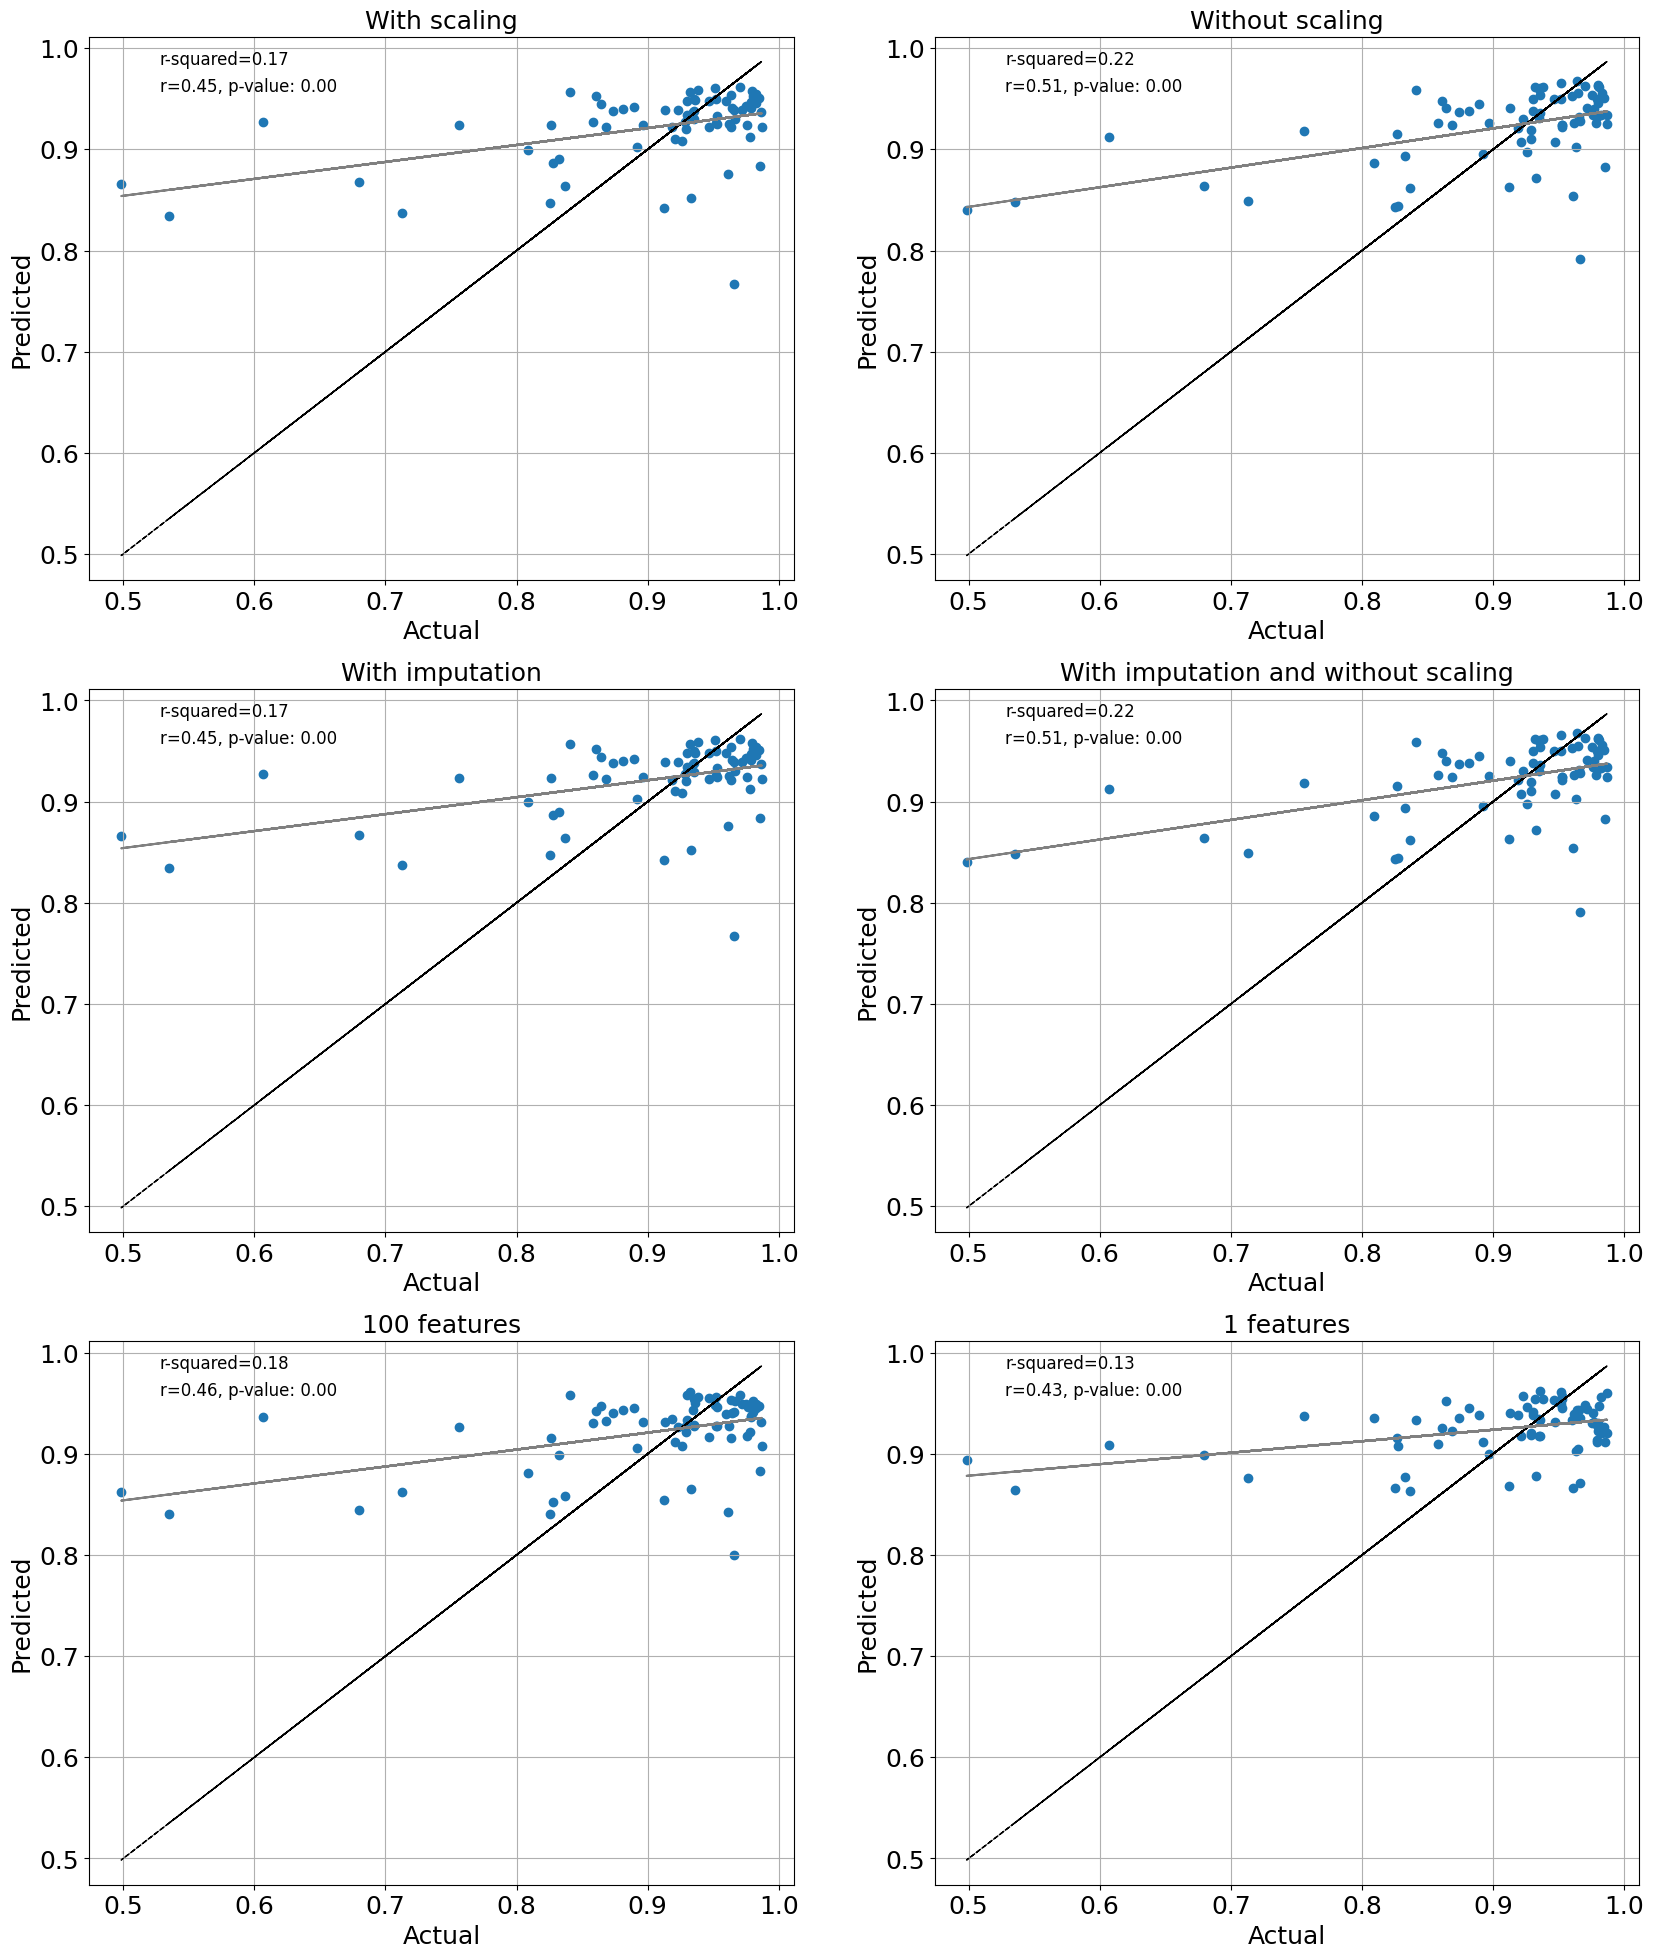

In [38]:
## Test a simple model run 

# split the data into train and test set

import Visualisation as vis
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import lasso regression model

from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LinearRegression

from sklearn.ensemble import RandomForestRegressor

# import feature selection

from sklearn.feature_selection import SelectKBest, f_regression

# import log transformation

from sklearn.preprocessing import FunctionTransformer

# import pipeline

from sklearn.pipeline import Pipeline

# import scaler

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# squared transform

sq_transform = FunctionTransformer(lambda x: x**2, validate=True)

import numpy as np

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1,
                                                    random_state=np.random.randint(1000))

# # plot the label distribution

import seaborn as sns

# sns.histplot(y_train, kde=True)

# sns.histplot(y_train_t, kde=True)

# sns.histplot(y_train_mm, kde=True)
# use the pipeline to fit the model

# create the pipeline

pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('feature_selection', SelectKBest(f_regression, k=200)),
                        ('model', ElasticNet(alpha=0.005, max_iter=100000))])

pipeline2 = Pipeline([('feature_selection', SelectKBest(f_regression, k=200)),
                        ('model', ElasticNet(alpha=0.005, max_iter=100000))])

pipeline3 = Pipeline([('imputer', FirstQuantileImputer()) ,
                      ('scaler', StandardScaler()), 
                      ('feature_selection', SelectKBest(f_regression, k=200)),
                        ('model', ElasticNet(alpha=0.005, max_iter=100000))])

pipeline4 = Pipeline([('imputer', FirstQuantileImputer()), 
                      ('feature_selection', SelectKBest(f_regression, k=200)),
                        ('model', ElasticNet(alpha=0.005, max_iter=100000))])

pipeline5 = Pipeline([('feature_selection', SelectKBest(f_regression, k=100)),
                        ('model', ElasticNet(alpha=0.005, max_iter=100000))])

pipeline6 = Pipeline([('feature_selection', SelectKBest(f_regression, k=1)),
                        ('model', ElasticNet(alpha=0.005, max_iter=100000))])

# fit the model

pipeline.fit(X_train, y_train)
pipeline2.fit(X_train, y_train)
pipeline3.fit(X_train, y_train)
pipeline4.fit(X_train, y_train)
pipeline5.fit(X_train, y_train)
pipeline6.fit(X_train, y_train)

# predict the test set

y_pred = pipeline.predict(X_test)
y_pred2 = pipeline2.predict(X_test)
y_pred3 = pipeline3.predict(X_test)
y_pred4 = pipeline4.predict(X_test)
y_pred5 = pipeline5.predict(X_test)
y_pred6 = pipeline6.predict(X_test)

# plot the predicted vs actual

fig, axes = plt.subplots(3, 2, figsize=(20, 24))

vis.plot_predictions_vs_actual_values(y_test, y_pred, "With scaling", 'Actual', 'Predicted', ax=axes[0][0])
vis.plot_predictions_vs_actual_values(y_test, y_pred2, "Without scaling", 'Actual', 'Predicted', ax=axes[0][1])
vis.plot_predictions_vs_actual_values(y_test, y_pred3, "With imputation", 'Actual', 'Predicted', ax=axes[1][0])
vis.plot_predictions_vs_actual_values(y_test, y_pred4, "With imputation and without scaling", 'Actual', 'Predicted', ax=axes[1][1])
vis.plot_predictions_vs_actual_values(y_test, y_pred5, "100 features", 'Actual', 'Predicted', ax=axes[2][0])
vis.plot_predictions_vs_actual_values(y_test, y_pred6, "1 features", 'Actual', 'Predicted', ax=axes[2][1])

plt.show()


In [ ]:
## Test Feature Size Effect on training performance between 0 to 500 

feature_size_tested = []
for i in range(1, 500, 10):
    feature_size_tested.append(i)

all_df = pd.DataFrame()

for feature_size in feature_size_tested:
    print(f'------------------ feature size: {feature_size}')
    feature_size_df = run_bulk_test(['random'], 
                                    [False], 
                                    [get_random_features], 
                                    [(feature_size,)],
                                    models_used, models_hyperparameters,
                                    rng_seed_lists, 
                                    feature_data, label_data,
                                    cv_split_size=cv_split_size, 
                                    verbose=False, 
                                    bulk_run_tag=f'feature_size_{feature_size}',
                                    save_output=False)
    # create a column for feature size for each row
    feature_size_df['feature_size'] = feature_size
    all_df = pd.concat([all_df, feature_size_df], axis=0)

In [15]:
all_df.shape

(2500, 14)

KeyError: 'y'

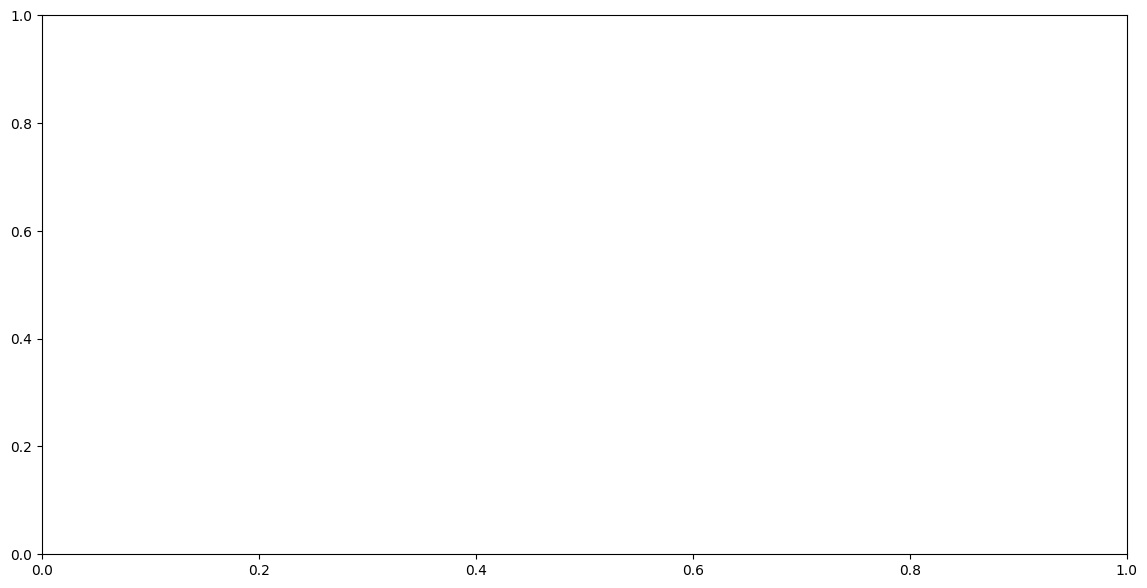

In [14]:
### plot the results

import seaborn as sns

# plot a line plot with error bars for pearson correlation

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x='feature_size', y='corr', data=all_df, ax=ax)
ax.set_title(f'Pearson correlation vs feature size')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.savefig(save_results_path+'feature_size_pearson_corr.png', dpi=300, bbox_inches='tight')
plt.show()